In [80]:
from scipy.linalg import svd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import dataset using ucimlrepo package

In [60]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data
df = wine_quality.data.original
df.columns

# red and white wine have different production methods and different chemical qualities (for example, red wines have higher tannins and lower sugar levels)
# thus, we will only be looking at red wine
df_red = df[df["color"] == "red"].copy()

X = df_red.drop(columns=["quality", "color"])
y = (df_red["quality"] >= 7).astype(int)

df = wine_quality.data.original
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color'],
      dtype='object')

## Classification

In [62]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y # random_state ensures random split of data is the same every time so our plots and numbers remain the same
                                                    # stratify ensures the class proportions are preserved in train and test sets which is useful since our dataset
                                                    # is unbalanced (i.e., more low quality (5220 rows) than high quality (1277 rows)
)

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

clf.fit(X_train_scaled, y_train)

# predictions
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

# accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(test_acc)

0.93125


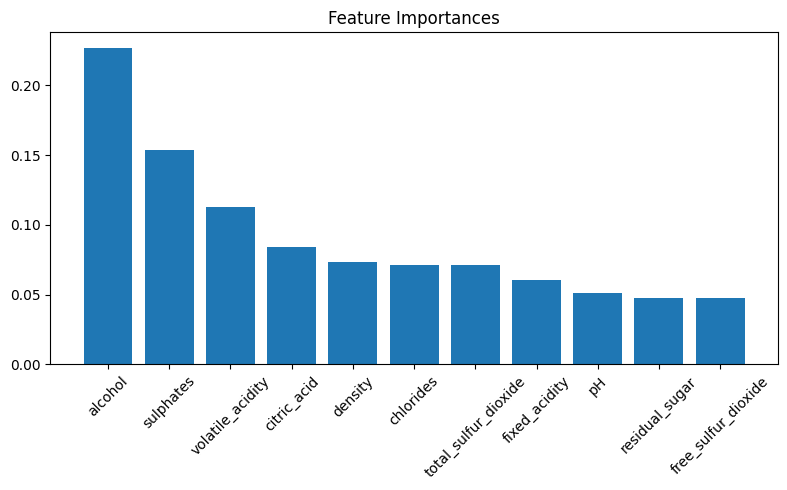

In [78]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), X.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

## Linear Dimension Reduction

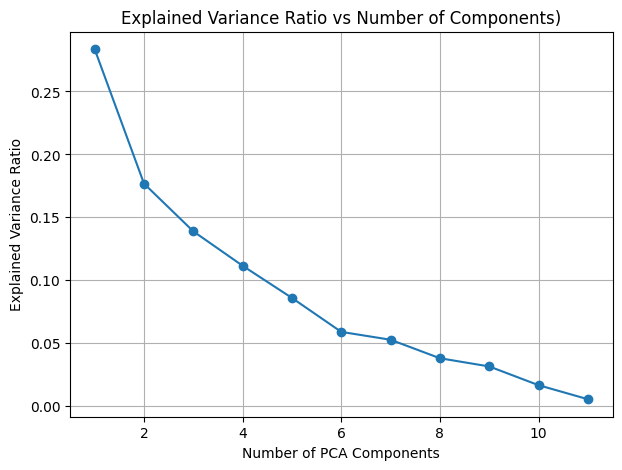

In [63]:
X_train_T = X_train_scaled.T
X_centered = X_train_T - np.mean(X_train_T, axis=1, keepdims=True)

U, s, _ = svd(X_centered, full_matrices=False)

N = X_centered.shape[1]
eigvals = (s**2) / (N - 1)
explained_variance_ratio = eigvals / np.sum(eigvals)

plt.figure(figsize=(7,5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components)")
plt.grid(True)
plt.show()

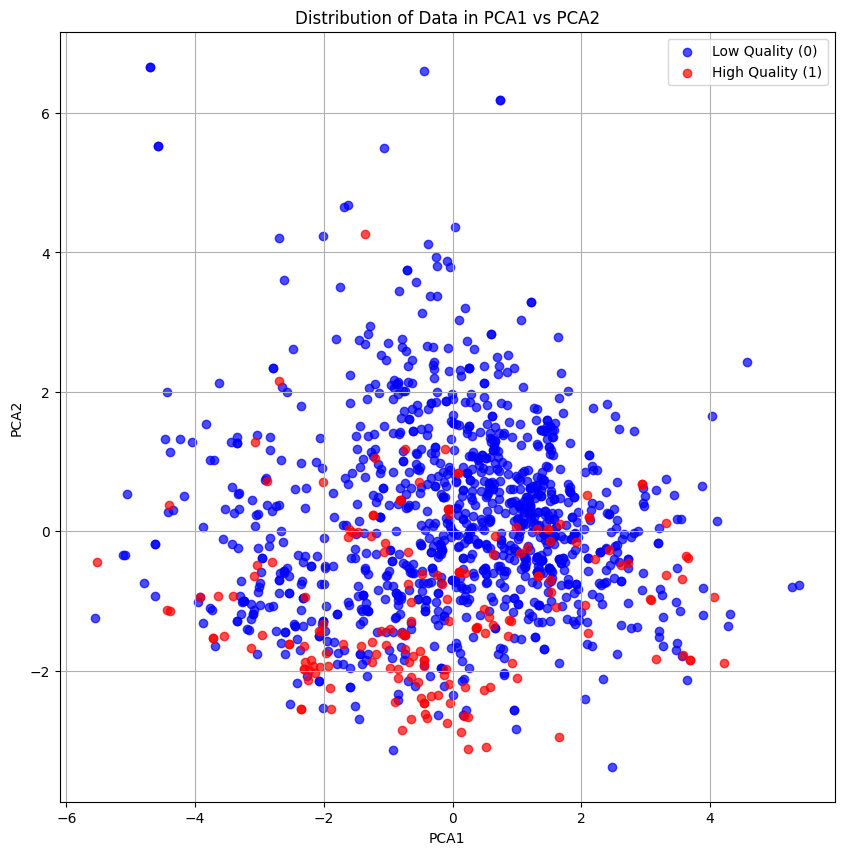

In [68]:
# Project onto first two principal components
PCs = U[:, :2]
Y_train_2D = PCs.T @ X_centered

Y_plot = Y_train_2D.T

plt.figure(figsize=(10,10))
plt.scatter(
    Y_plot[y_train == 0, 0],
    Y_plot[y_train == 0, 1],
    label="Low Quality (0)",
    alpha=0.7,
    color="blue"
)

plt.scatter(
    Y_plot[y_train == 1, 0],
    Y_plot[y_train == 1, 1],
    label="High Quality (1)",
    alpha=0.7,
    color="red"
)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Distribution of Data in PCA1 vs PCA2")
plt.legend()
plt.grid(True)
plt.show()


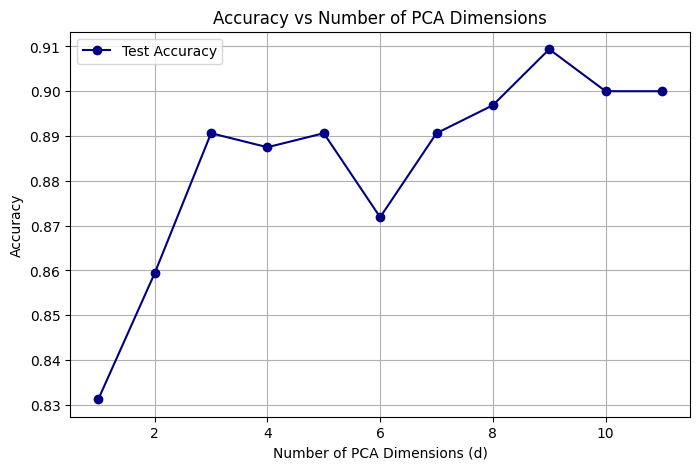

In [77]:
def pca(X, d):
    mu = np.mean(X, axis=1, keepdims=True)
    X_center = X - mu
    U, _, _ = svd(X_center, full_matrices=False)
    Ud = U[:, :d]
    Y = Ud.T @ X_center
    return mu, Ud, Y

def one_nn_accuracy(Y_train, y_train, Y_test, y_test):
    correct = 0
    for i in range(Y_test.shape[1]):
        distances = np.linalg.norm(Y_train - Y_test[:, i][:, None], axis=0)
        nn_idx = np.argmin(distances)
        if y_train[nn_idx] == y_test[i]:
            correct += 1
    return correct / len(y_test)

X_test_T = X_test_scaled.T

dims = range(1, X_train_T.shape[0] + 1)
test_acc = []

for d in dims:
    mu, U, Y_train = pca(X_train_T, d)
    Y_test = U.T @ (X_test_T - mu)
    acc = one_nn_accuracy(Y_train, y_train.values, Y_test, y_test.values)
    test_acc.append(acc)

plt.figure(figsize=(8,5))
plt.plot(dims, test_acc, marker='o', color='navy', label="Test Accuracy")
plt.xlabel("Number of PCA Dimensions (d)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of PCA Dimensions")
plt.grid(True)
plt.legend()
plt.show()

In [84]:
loadings = pd.DataFrame(U, index=X.columns, columns=[f"PC{i+1}" for i in range(U.shape[1])])
print(loadings)

                           PC1       PC2       PC3       PC4       PC5  \
fixed_acidity        -0.488307 -0.105901  0.120398 -0.222136  0.079909   
volatile_acidity      0.238143  0.288636  0.439816  0.101726 -0.203418   
citric_acid          -0.458350 -0.161020 -0.234962 -0.080632  0.064494   
residual_sugar       -0.147672  0.284408 -0.103865 -0.372026 -0.720708   
chlorides            -0.205946  0.141558  0.075296  0.680375 -0.252013   
free_sulfur_dioxide   0.028509  0.514056 -0.427833 -0.054339  0.176175   
total_sulfur_dioxide -0.027687  0.566206 -0.315024 -0.022827  0.250284   
density              -0.401132  0.232105  0.320368 -0.172301 -0.182292   
pH                    0.438540  0.019711 -0.078642 -0.015870 -0.279061   
sulphates            -0.238862 -0.053988 -0.325016  0.527548 -0.229168   
alcohol               0.136671 -0.369596 -0.472932 -0.144128 -0.328395   

                           PC6       PC7       PC8       PC9      PC10  \
fixed_acidity        -0.163137  0.346

In [ ]:
# TO-DO: analyze these relationships ^^